# MultiClass AUM , ROC and AUC using torch

The goal of this notebook is to show and to explain how to compute the new [AUM](https://www.jmlr.org/papers/v24/21-0751.html) for multiclass classification using the One-versus-All approach where the problem is reduced to multiple binary classification problems. In this notebook I will use micro-averaging( I borrowed the term from scikit-learn): instead of computing a metric(False positive rate for example ) for each binary classification problem,  and then averaging it , I will aggregate false positives and false negatives and then compute the metric. In my approach , I used probabilities (using softmax on the output) instead of scores 
- For explanations and interpretations of the ROC curve , please visit this [blog](https://tdhock.github.io/blog/2024/torch-roc-aum/)

## Import python modules 

In [3]:
import torch
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import plotnine as p9

## Computing the ROC Curve
- To compute the ROC curve using micro-averaging , we need to first compute False positives (FP) , false negatives (FN) and thresholds where change happens in False positive rate (FPR) and/or True Positive rate(TPR). These thresholds are exactly the opposite of the predicted probability of an example.

- I used one hot encoding to avoid using loops in my code. Each column of the one hot tensor will serve to compute FPs and FNs for one binary classification problem and each column of the prediction tensor will serve to get thresholds for one binary classification problem.

- I then flattened all the tensors to aggregate all FPs , FNs and thresholds into one big 1D tensor ( of size KN , where K is the number of classes and N is the number of examples in the dataset) which I used to compute FPR and TPR to draw the ROC_curve

In [4]:
def ROC_curve(pred_tensor, label_tensor):
    n_class=pred_tensor.size(1)
    one_hot_labels = F.one_hot(label_tensor, num_classes=n_class) 
    is_positive = one_hot_labels
    is_negative =1-one_hot_labels
    fn_diff = -is_positive.flatten()
    fp_diff = is_negative.flatten()
    thresh_tensor = -pred_tensor.flatten()
    fn_denom = is_positive.sum()
    fp_denom = is_negative.sum()
    sorted_indices = torch.argsort(thresh_tensor)
    sorted_fp_cum = fp_diff[sorted_indices].cumsum(0) / fp_denom
    sorted_fn_cum = -fn_diff[sorted_indices].flip(0).cumsum(0).flip(0) / fn_denom

    sorted_thresh = thresh_tensor[sorted_indices]
    sorted_is_diff = sorted_thresh.diff() != 0
    sorted_fp_end = torch.cat([sorted_is_diff, torch.tensor([True])])
    sorted_fn_end = torch.cat([torch.tensor([True]), sorted_is_diff])

    uniq_thresh = sorted_thresh[sorted_fp_end]
    uniq_fp_after = sorted_fp_cum[sorted_fp_end]
    uniq_fn_before = sorted_fn_cum[sorted_fn_end]

    FPR = torch.cat([torch.tensor([0.0]), uniq_fp_after])
    FNR = torch.cat([uniq_fn_before, torch.tensor([0.0])])

    return {
        "FPR": FPR,
        "FNR": FNR,
        "TPR": 1 - FNR,
        "min(FPR,FNR)": torch.minimum(FPR, FNR),
        "min_constant": torch.cat([torch.tensor([-1]), uniq_thresh]),
        "max_constant": torch.cat([uniq_thresh, torch.tensor([0])])
    }

## Computing AUCROC and AUM
- I used the code in this [blog](https://tdhock.github.io/blog/2024/torch-roc-aum/) as it is similar to the binary classification case

In [ ]:
#AUC
def ROC_AUC(pred_tensor, label_tensor):
    roc = ROC_curve(pred_tensor, label_tensor)
    FPR_diff = roc["FPR"][1:]-roc["FPR"][:-1]   
    TPR_sum = roc["TPR"][1:]+roc["TPR"][:-1]
    return torch.sum(FPR_diff*TPR_sum/2.0)
#AUM 
def Proposed_AUM(pred_tensor, label_tensor):

    roc = ROC_curve(pred_tensor, label_tensor)
    min_FPR_FNR = roc["min(FPR,FNR)"][1:-1]
    constant_diff = roc["min_constant"][1:].diff()
    return torch.sum(min_FPR_FNR * constant_diff)

## Examples of AUC and AUM-Multiclass for 3 different predictions for the same dataset

In [6]:
four_labels = torch.tensor([0,2,1,1])
four_pred_perfect = F.one_hot(four_labels, num_classes=3)
four_pred_anti=torch.tensor([[0,1,0],
                             [0,1,0],
                             [1,0,0],
                             [1,0,0]]) 
four_pred_const=torch.tensor([[1,0,0],
                              [1,0,0],
                              [1,0,0],
                              [1,0,0]])

In the code presented below, the Area Under the Curve  and the Area Under the Minimum  were computed for each of the predictions. And the ROC curve was plotted . There seems to be  an inverse relationship between AUM and AUC, with lower AUM values observed when AUC is high.

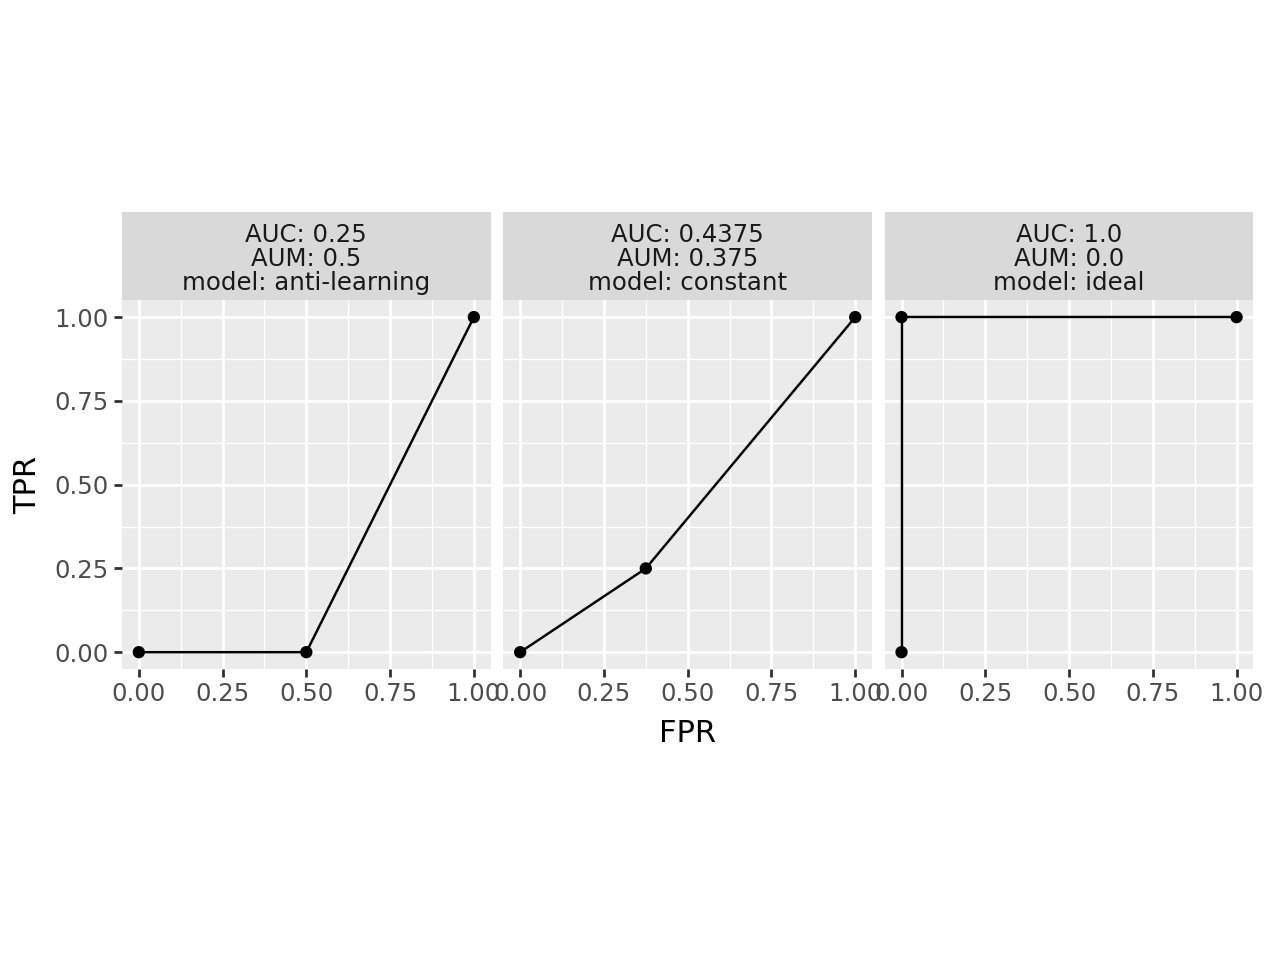

In [7]:
pred_dict = {
    "ideal":four_pred_perfect,
    "constant":four_pred_const,
    "anti-learning":four_pred_anti,
}
example_roc_df_list = []
for model, pred_tensor in pred_dict.items():
    one_roc = ROC_curve(pred_tensor, four_labels)
    one_roc['model']=model
    one_roc["AUC"]=ROC_AUC(pred_tensor, four_labels).numpy()
    one_roc["AUM"]=Proposed_AUM(pred_tensor,four_labels).numpy()
    example_roc_df_list.append(pd.DataFrame(one_roc))
example_roc_df = pd.concat(example_roc_df_list)
gg_roc_example = p9.ggplot()+\
    p9.facet_grid(". ~ AUC + AUM + model", labeller="label_both")+\
    p9.coord_equal()+\
    p9.geom_line(
        p9.aes(
            x="FPR",
            y="TPR",
        ),
        data=example_roc_df
    )+\
    p9.geom_point(
        p9.aes(
            x="FPR",
            y="TPR",
        ),
        data=example_roc_df
    )
gg_roc_example

## Training a linear model on MNIST dataset using the AUM above as the loss function

In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

mnist_train = datasets.MNIST(root='./data', train=True, download=False, transform=transforms.ToTensor())
mnist_test = datasets.MNIST(root='./data', train=False, download=False, transform=transforms.ToTensor())
full_size = len(mnist_train) 
train_loader = DataLoader(mnist_train, batch_size=full_size, shuffle=False)
data_iter = iter(train_loader)
images_full, labels = next(data_iter)
images=images_full.view(images_full.size(0), -1)
images.size()

torch.Size([60000, 784])

In [12]:
class LinearClassifier_AUM(nn.Module):
    def __init__(self, input_dim, n_class):
        super(LinearClassifier_AUM, self).__init__()
        self.linear = nn.Linear(input_dim, n_class)
    
    def forward(self, x):
        logits = self.linear(x)
        probs = F.softmax(logits, dim=1) 
        return probs
    
model = LinearClassifier_AUM(input_dim=784, n_class=10)
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)


In [ ]:
AUC_evolution=[]
AUM_evolution=[]


# Training step
model.train()
df_list=[]
n_epochs=1000
for epoch in range(n_epochs):
    probs = model(images)
    if epoch==0 or epoch==n_epochs-1:
        df_list.append(ROC_curve(probs,labels))
    loss = Proposed_AUM(probs, labels)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    AUC_evolution.append(ROC_AUC(probs,labels).item())
    AUM_evolution.append(Proposed_AUM(probs, labels).detach().item())
Evolution={"AUM":AUM_evolution,
           "AUC":AUC_evolution}
Evolution_df=pd.DataFrame(Evolution)    

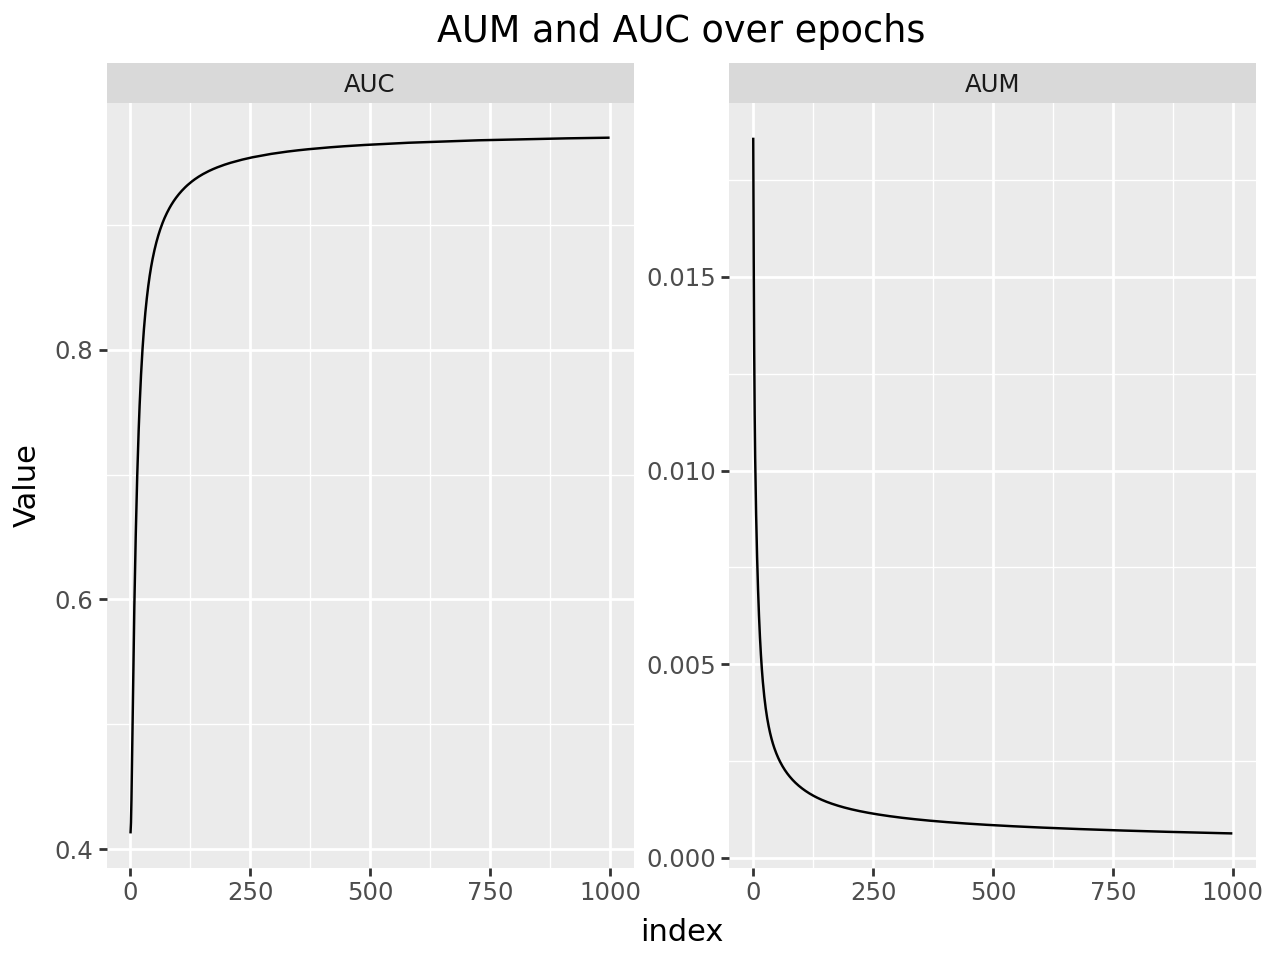

In [15]:

df = Evolution_df.reset_index()
df_long = df.melt(id_vars='index', value_vars=['AUM', 'AUC'],
                  var_name='Metric', value_name='Value')

# Plot using facet_wrap
plot = (
    p9.ggplot(df_long, p9.aes(x='index', y='Value')) +
    p9.geom_line() +
    p9.facet_wrap('~ Metric', scales='free_y') +
    p9.labs(title='AUM and AUC over epochs', x='index', y='Value')
)
plot

The figure above shows the inverse relationship between AUC and AUM : when AUM decreases , AUC increases

In [27]:
df_list[0]["AUC"]=torch.tensor(Evolution["AUC"][0])
df_list[-1]["AUC"]=torch.tensor(Evolution["AUC"][-1])
list_=[]
for df in df_list:
    df = pd.DataFrame({k: v.detach().numpy() if v.requires_grad else v.numpy() for k, v in df.items()})
    list_.append(df)

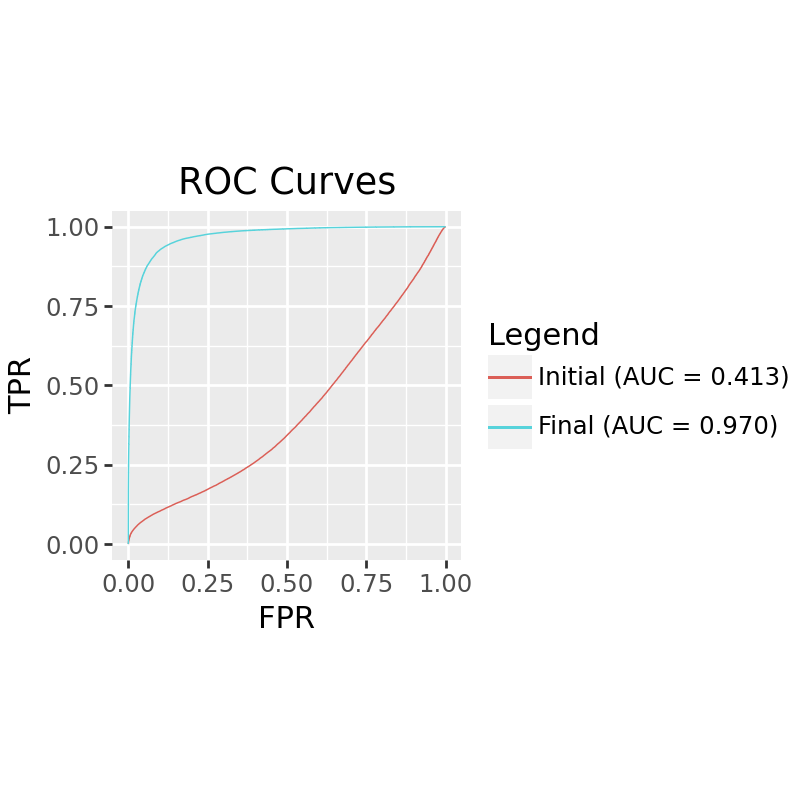

In [28]:
auc_initial=list_[0].iloc[0,-1]
auc_final=list_[-1].iloc[0,-1]
label_initial = f'Initial (AUC = {auc_initial:.3f})'
label_final = f'Final (AUC = {auc_final:.3f})'
gg_plot_roc = p9.ggplot()+\
    p9.theme(figure_size=(4,4))+\
    p9.coord_equal()+\
    p9.geom_line(
        data=list_[0],
        mapping=p9.aes(x="FPR", y="TPR", color=f'"{label_initial}"'),
        size=0.3
    )+\
    p9.geom_line(
        data=list_[-1],
        mapping=p9.aes(x="FPR", y="TPR", color=f'"{label_final}"'),
        size=0.3
    )+\
     p9.labs(color="Legend", title="ROC Curves")
gg_plot_roc

The figure above shows the ROC curves for the model before and after training. The figure shows significant improvement   from a near random   (AUC = 0.413) to a very strong one (AUC = 0.970) when trained on the AUM .